In [42]:
#import libraries

import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, r2_score,roc_auc_score

import matplotlib.pyplot as plt


#read in data
data = pd.read_csv('../Data/training_set_features.csv',index_col = 'respondent_id')
#read target
target = pd.read_csv('../Data/training_set_labels.csv',index_col = 'respondent_id')

#merge into df
df = pd.concat([data,target])
print(df.columns)


Index(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race', 'sex', 'income_poverty', 'marital_status',
       'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa',
       'household_adults', 'household_children', 'employment_industry',
       'employment_occupation', 'h1n1_vaccine', 'seasonal_vaccine'],
      dtype='object')


In [3]:
#select h1n1 target, drop seasonal vaccine columns, drop irrelevant columns


drop_cols = ['opinion_seas_vacc_effective','opinion_seas_risk','opinion_seas_sick_from_vacc','hhs_geo_region',
            'employment_industry','employment_occupation','census_msa','seasonal_vaccine']

df.drop(labels= drop_cols, axis=1,inplace=True)

df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53414 entries, 0 to 26706
Data columns (total 29 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 26615 non-null  float64
 1   h1n1_knowledge               26591 non-null  float64
 2   behavioral_antiviral_meds    26636 non-null  float64
 3   behavioral_avoidance         26499 non-null  float64
 4   behavioral_face_mask         26688 non-null  float64
 5   behavioral_wash_hands        26665 non-null  float64
 6   behavioral_large_gatherings  26620 non-null  float64
 7   behavioral_outside_home      26625 non-null  float64
 8   behavioral_touch_face        26579 non-null  float64
 9   doctor_recc_h1n1             24547 non-null  float64
 10  doctor_recc_seasonal         24547 non-null  float64
 11  chronic_med_condition        25736 non-null  float64
 12  child_under_6_months         25887 non-null  float64
 13  health_worker   

In [4]:
#investigate target imbalance

df['h1n1_vaccine'].value_counts()

df['h1n1_vaccine'].isna().value_counts()


# split target off from data set
target = pd.DataFrame(df['h1n1_vaccine'])

target.value_counts()

h1n1_vaccine
0.0             21033
1.0              5674
dtype: int64

In [5]:
#investigate categorical vars
print(df['health_insurance'].value_counts())
print(df['education'].value_counts())

1.0    12697
0.0     1736
Name: health_insurance, dtype: int64
College Graduate    10097
Some College         7043
12 Years             5797
< 12 Years           2363
Name: education, dtype: int64


In [10]:
#drop target from df
df.info()

data = df.drop('h1n1_vaccine',axis=1, inplace=False)

#drop all rows with any NaN values

data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53414 entries, 0 to 26706
Data columns (total 29 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 26615 non-null  float64
 1   h1n1_knowledge               26591 non-null  float64
 2   behavioral_antiviral_meds    26636 non-null  float64
 3   behavioral_avoidance         26499 non-null  float64
 4   behavioral_face_mask         26688 non-null  float64
 5   behavioral_wash_hands        26665 non-null  float64
 6   behavioral_large_gatherings  26620 non-null  float64
 7   behavioral_outside_home      26625 non-null  float64
 8   behavioral_touch_face        26579 non-null  float64
 9   doctor_recc_h1n1             24547 non-null  float64
 10  doctor_recc_seasonal         24547 non-null  float64
 11  chronic_med_condition        25736 non-null  float64
 12  child_under_6_months         25887 non-null  float64
 13  health_worker   

In [15]:

#modify object columns into dummies
data = pd.get_dummies(data)


data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 11802 entries, 0 to 26706
Data columns (total 45 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   h1n1_concern                              11802 non-null  float64
 1   h1n1_knowledge                            11802 non-null  float64
 2   behavioral_antiviral_meds                 11802 non-null  float64
 3   behavioral_avoidance                      11802 non-null  float64
 4   behavioral_face_mask                      11802 non-null  float64
 5   behavioral_wash_hands                     11802 non-null  float64
 6   behavioral_large_gatherings               11802 non-null  float64
 7   behavioral_outside_home                   11802 non-null  float64
 8   behavioral_touch_face                     11802 non-null  float64
 9   doctor_recc_h1n1                          11802 non-null  float64
 10  doctor_recc_seasonal              

In [46]:
#merge back to match indices & size

merge_df = data.merge(target,how='left',on='respondent_id')



merge_df.dropna(inplace=True)

merge_df.describe()

#split back into X,y

y = merge_df['h1n1_vaccine']
X = merge_df.drop('h1n1_vaccine',axis=1,inplace=False)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.25)

#instantiate default DecisionTreeClassifier

initial_tree = DecisionTreeClassifier()


#fit to train

initial_tree.fit(X_train,y_train)

DecisionTreeClassifier()

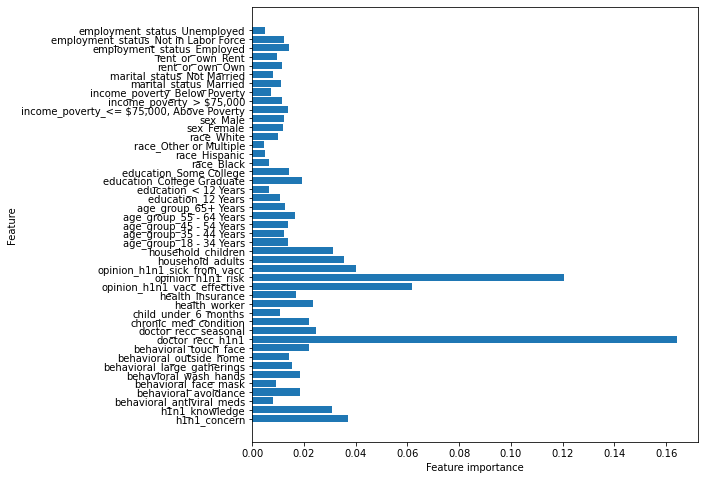

In [34]:
#test feature importance

def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances(initial_tree)


#citation: tree lab

In [44]:
#initial tree scores

initial_dc_tree_score = initial_tree.score(X_test,y_test)
print('initial_dc_tree_score:', initial_dc_tree_score)


#cross val score

cv_initial_tree = cross_val_score(initial_tree,X,y)

print("5 fold cross val for initial dc model:", cv_initial_tree)

initial_dc_tree_score: 0.7173839376482548
5 fold cross val for initial dc model: [0.71283355 0.72850487 0.72923729 0.7309322  0.725     ]


In [45]:
#assess default logistic regression model

initial_logreg = LogisticRegression(max_iter=1000)


#default max_iter = 100 does not converge
initial_logreg.fit(X_train,y_train)

initial_logreg_score = initial_logreg.score(X_test,y_test)

cv_initial_logreg = cross_val_score(initial_logreg,X,y)

print("initial logistic regression score: ", initial_logreg_score)

print("5 fold cross val for initial logreg model:", cv_initial_logreg)

initial logistic regression score:  0.8085394781430024
5 fold cross val for initial logreg model: [0.82507412 0.81321474 0.82076271 0.82457627 0.81101695]


In [ ]:
#bagging tree classifier

